In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

sns.set_style('whitegrid')
sns.set_palette('Blues')
np.random.seed(427)

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('../data/processed/crime_incidences.csv')
df = df[df.region == 'NCR']

In [3]:
df.head()

,crime,crimetype,customdate,customtime,date,date_com,datechar,lat,lng,location,modus,moduscode,province,region,station,time,hour
128034,Drug Related Incident (RA 9165),916,"Thu - Aug 3, 2017",4:00:PM,2017-08-03,2017-08-03,42950,14.5395,121.068,"San Roque, Pateros, Ncr District 4 (Southern),...",Not Indicated,mc00,Ncr District 4 (Southern),NCR,Police Station 06 Pateros,16:00:00,16
128035,Vehicular Traffic Accident,123,"Thu - Aug 3, 2017",7:00:AM,2017-08-03,2017-08-03,42950,14.5763,121.039,"Poblacion, City of Mandaluyong, Ncr District 2...",Not Indicated,mc00,Ncr District 2 (Eastern),NCR,Police Station 03 Mandaluyong City,07:00:00,7
128036,Vehicular Traffic Accident,123,"Thu - Aug 3, 2017",6:20:AM,2017-08-03,2017-08-03,42950,14.6252,121.083,"Calumpang, City of Marikina, Ncr District 2 (E...",Not Indicated,mc00,Ncr District 2 (Eastern),NCR,Police Station 01 Marikina City,06:20:00,6
128037,Vehicular Traffic Accident,123,"Thu - Aug 3, 2017",5:45:AM,2017-08-03,2017-08-03,42950,14.6343,121.087,"Tañong, City of Marikina, Ncr District 2 (East...",Not Indicated,mc00,Ncr District 2 (Eastern),NCR,Police Station 01 Marikina City,05:45:00,5
128038,ROBBERY,8,"Thu - Aug 3, 2017",3:00:AM,2017-08-03,2017-08-03,42950,14.6674,121.073,"Old Balara, Batasan, Quezon City, NCR",Hold-Up W/ Sharp Object,mc55,Quezon City,NCR,Police Station 06 Batasan,03:00:00,3


Text(0.5,1,'Did the crime incidences change over time?')

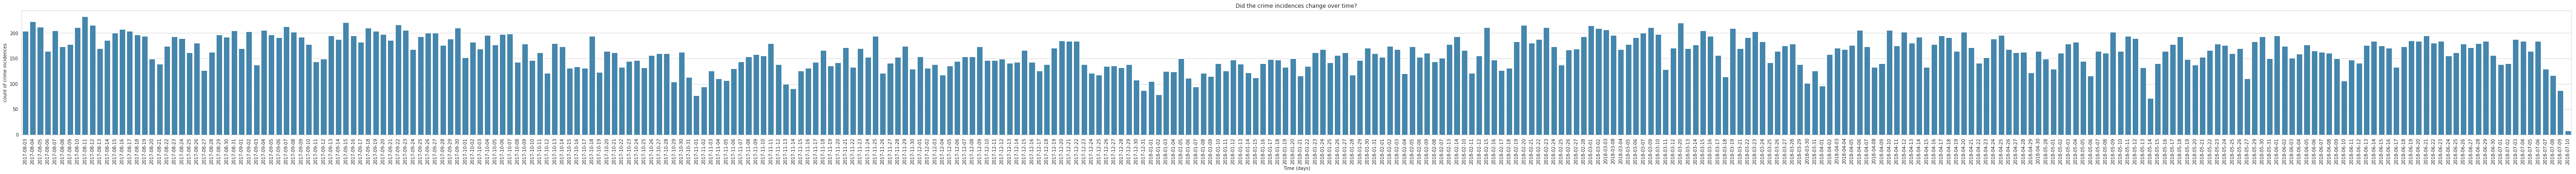

In [4]:
figsize(100, 5)
g = sns.countplot(x=df.date, color='#348ABD')
x = g.set_xticklabels(g.get_xticklabels(), rotation=90)
xlabel('Time (days)')
ylabel('count of crime incidences')
title('Did the crime incidences change over time?')

## All crime incidences

In [5]:
count_data = df.groupby('date')['crime'].count()

In [6]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(count_data) - 1)
    idx = np.arange(len(count_data))
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [7]:
with model:
    step = pm.NUTS()
    trace = pm.sample(35000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains: 100%|██████████| 160000/160000 [00:46<00:00, 3409.39draws/s]
/home/hadrian/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 10% for some parameters.


In [8]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

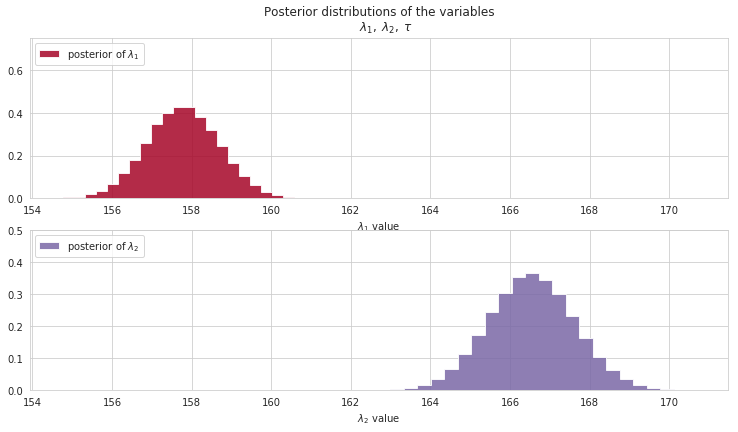

In [9]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

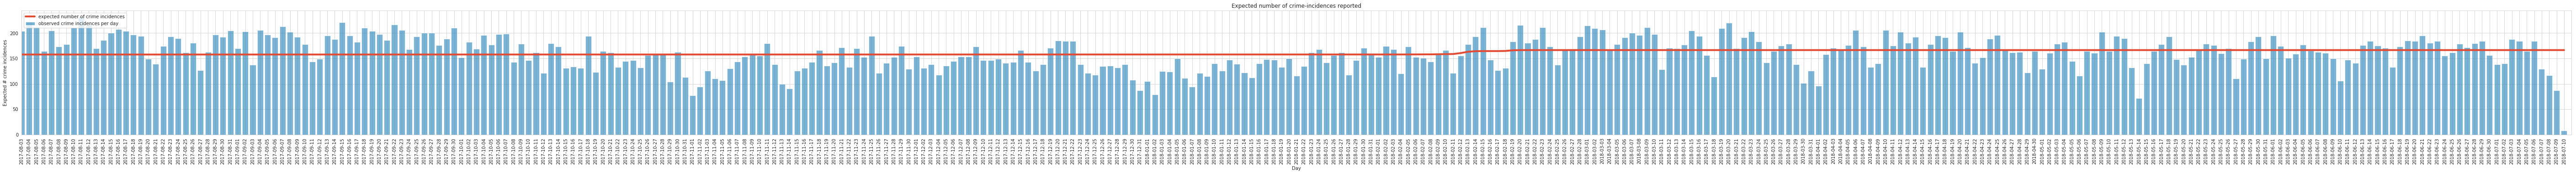

In [10]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of crime incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of crime-incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

In [11]:
print(f'% Decrease of crime: {1 - (lambda_2_samples / lambda_1_samples).mean()}')

% Decrease of crime: -0.055507094268758994


In [12]:
def by_crime_type(crime_type):
    count_data = df[df.crime == crime_type].groupby('date')['crime'].count()
    print('Creating model..')
    with pm.Model() as model:
        alpha = 1.0/count_data.mean()
        lambda_1 = pm.Exponential('lambda_1', alpha)
        lambda_2 = pm.Exponential('lambda_2', alpha)
        tau = pm.DiscreteUniform('tau', lower=0, upper=len(count_data) - 1)
        idx = np.arange(len(count_data))
        lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
        observation = pm.Poisson('obs', lambda_, observed=count_data)
    print('Running MCMC..')
    with model:
        step = pm.NUTS()
        trace = pm.sample(35000, tune=5000,step=step)
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    tau_samples = trace['tau']
    print(f'% Decrease of crime: {1 - (lambda_2_samples / lambda_1_samples).mean()}')
    return (lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data)

## Homicide Incidences

In [13]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type('HOMICIDE')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains: 100%|██████████| 160000/160000 [01:00<00:00, 2626.30draws/s]
/home/hadrian/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8901957494657262, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9022809485874967, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


% Decrease of crime: 0.03712054715574753


/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

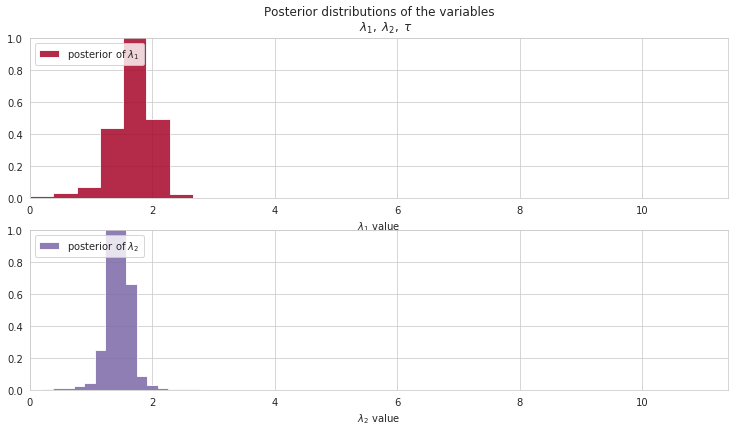

In [14]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

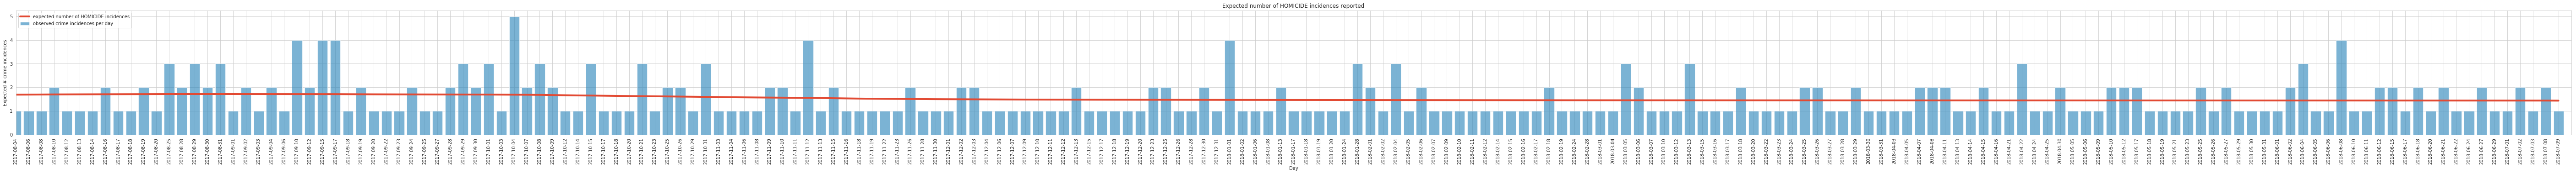

In [15]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of HOMICIDE incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of HOMICIDE incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Murder

In [16]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type('MURDER')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains: 100%|██████████| 160000/160000 [00:50<00:00, 3165.88draws/s]
/home/hadrian/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 25% for some parameters.


% Decrease of crime: 0.4585027979156845


/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

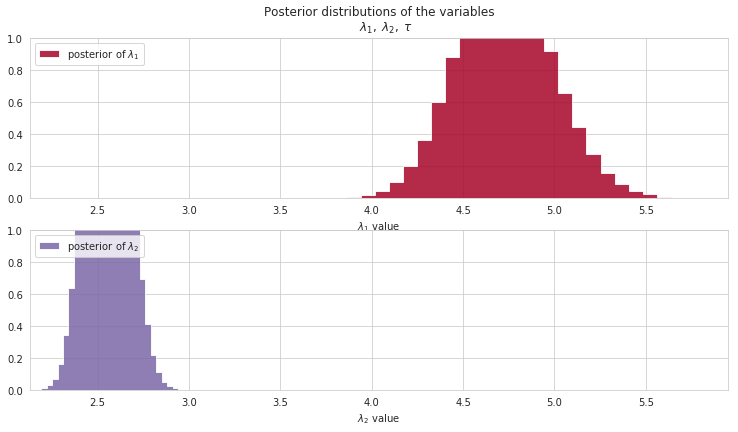

In [17]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

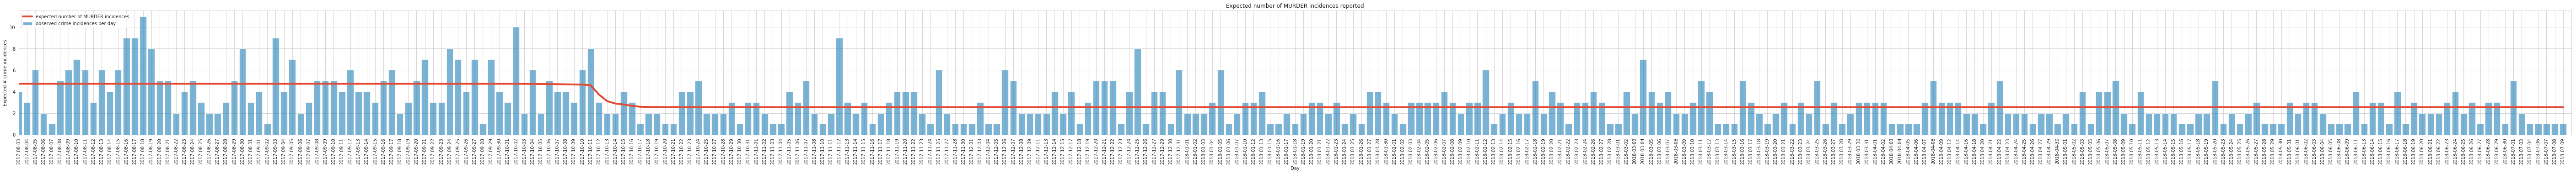

In [18]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of MURDER incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of MURDER incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Theft Incidences

In [19]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type(
    'THEFT')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains: 100%|██████████| 160000/160000 [00:50<00:00, 3161.51draws/s]
/home/hadrian/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


% Decrease of crime: 0.3367051630554575


/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

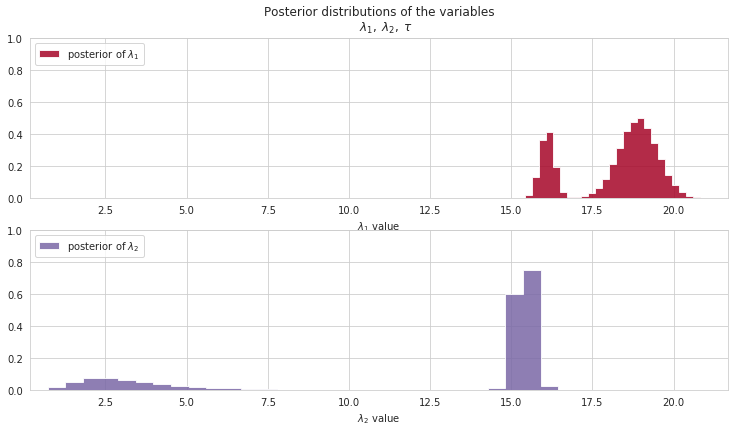

In [20]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

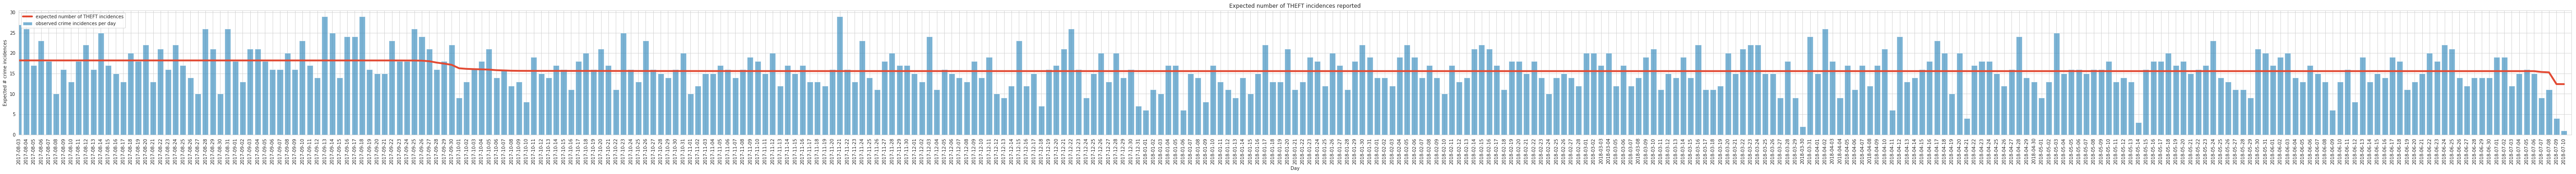

In [21]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of THEFT incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of THEFT incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Robbery

In [22]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type('ROBBERY')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains: 100%|██████████| 160000/160000 [00:46<00:00, 3421.88draws/s]
/home/hadrian/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 10% for some parameters.


% Decrease of crime: 0.19061692445202227


/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

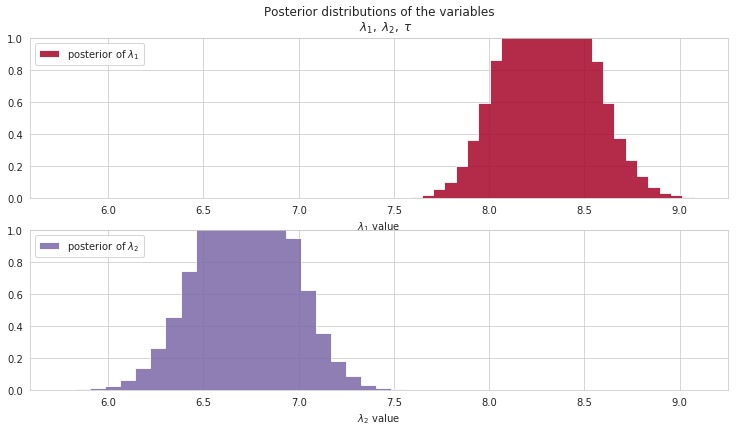

In [23]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

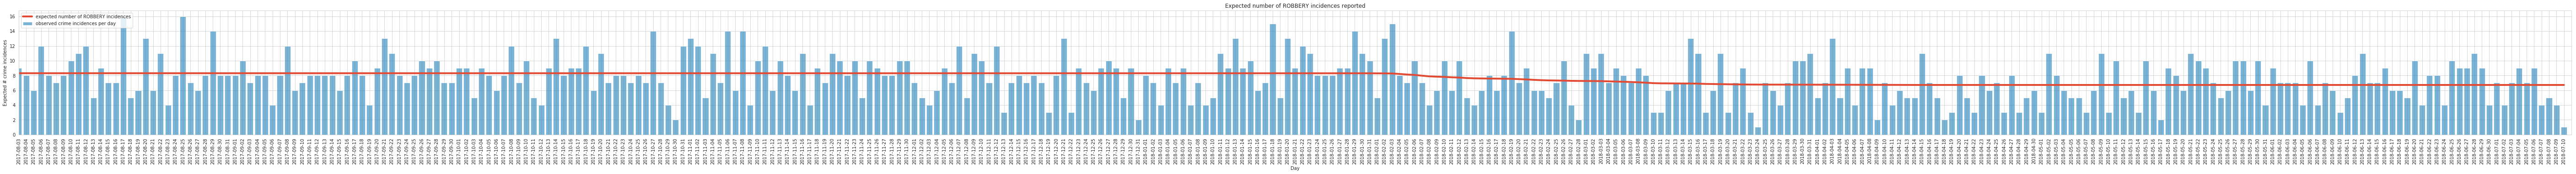

In [24]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of ROBBERY incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of ROBBERY incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Drug Related Incident (RA 9165)

In [25]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type(
    'Drug Related Incident (RA 9165)')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains: 100%|██████████| 160000/160000 [00:51<00:00, 3087.89draws/s]
/home/hadrian/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 25% for some parameters.


% Decrease of crime: -1.1736771011382126


/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

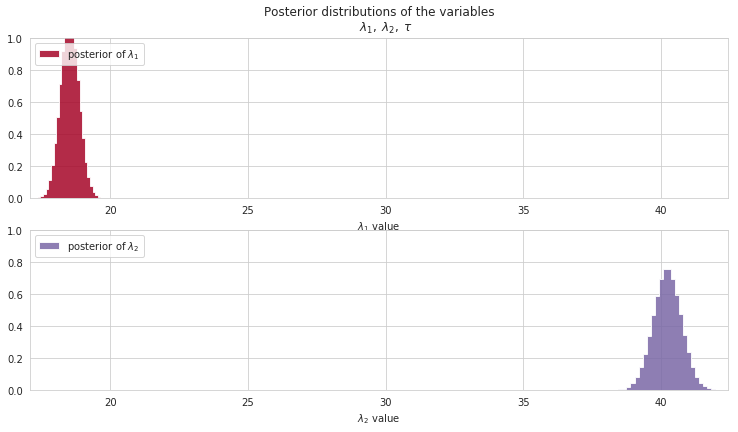

In [26]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

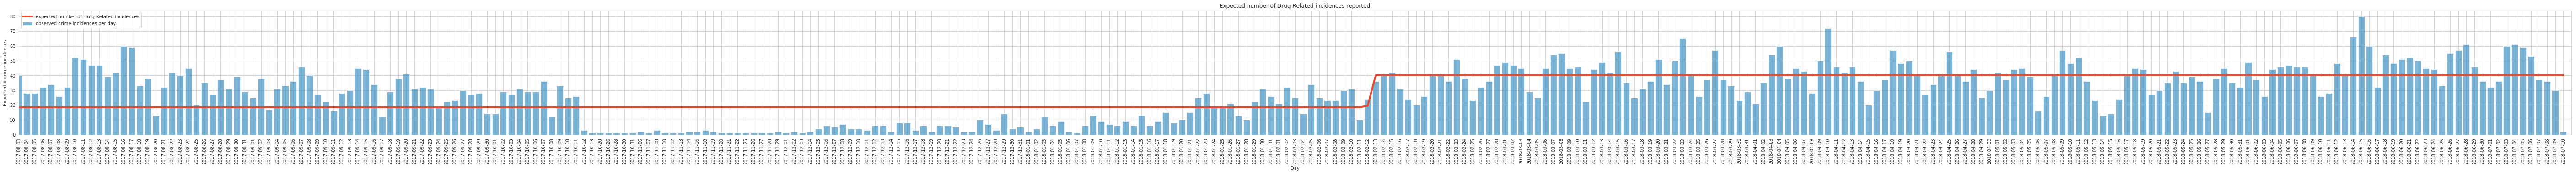

In [27]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of Drug Related incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of Drug Related incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## RAPE (Art. 266-A RC & R.A.8353)

In [28]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type(
    'RAPE (Art. 266-A RC & R.A.8353)')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains: 100%|██████████| 160000/160000 [00:56<00:00, 2818.17draws/s]
/home/hadrian/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2231 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5032017207844226, but

% Decrease of crime: 0.2820070635693598


/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

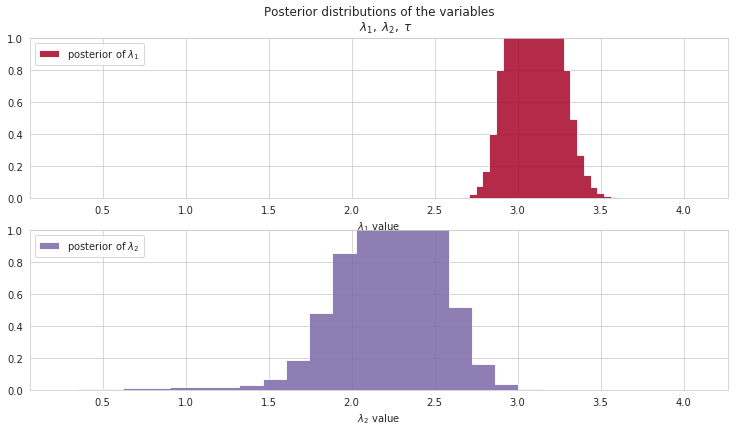

In [29]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

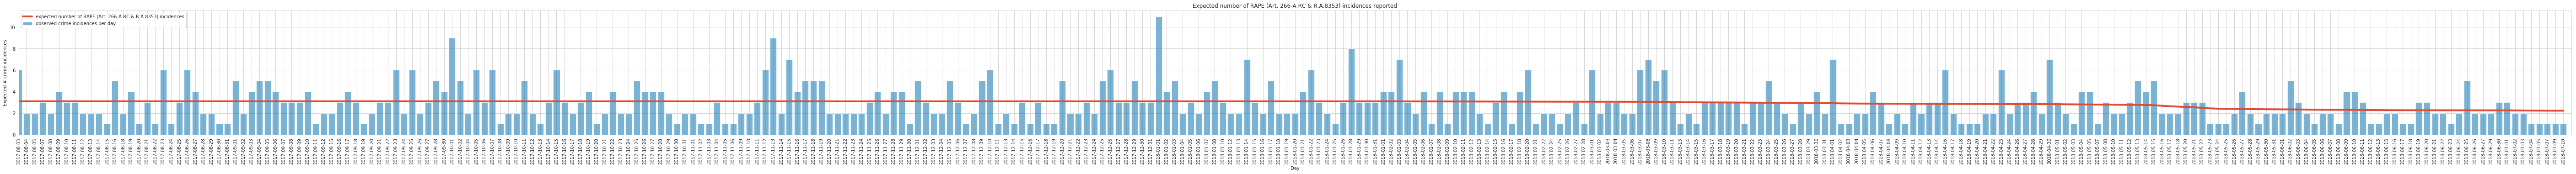

In [30]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of RAPE (Art. 266-A RC & R.A.8353) incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of RAPE (Art. 266-A RC & R.A.8353) incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Vehicular Traffic Accident

In [31]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type(
    'Vehicular Traffic Accident')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains: 100%|██████████| 160000/160000 [00:48<00:00, 3286.40draws/s]
/home/hadrian/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 25% for some parameters.


% Decrease of crime: 0.14777058818613553


/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

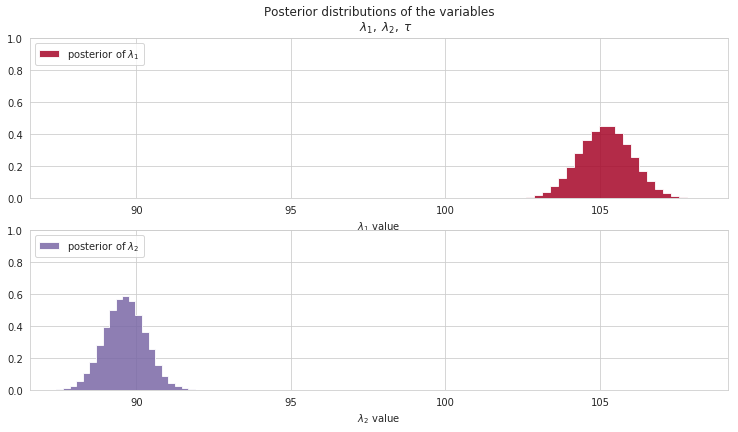

In [32]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

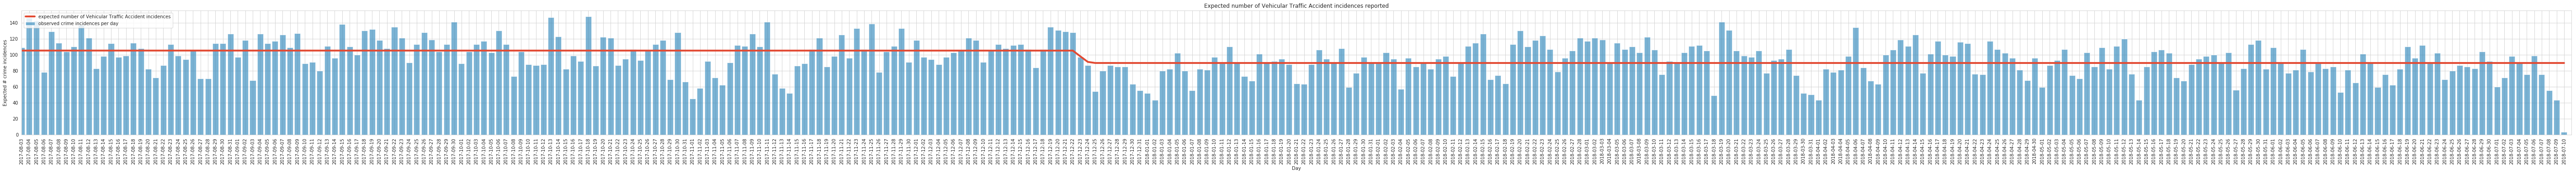

In [33]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of Vehicular Traffic Accident incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of Vehicular Traffic Accident incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Physical Injuries

In [34]:
lambda_1_samples, lambda_2_samples, tau_samples, count_data, n_count_data = by_crime_type(
    'PHYSICAL INJURIES')

Creating model..
Running MCMC..


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains: 100%|██████████| 160000/160000 [00:46<00:00, 3433.56draws/s]
/home/hadrian/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 10% for some parameters.


% Decrease of crime: 0.32236743950371527


/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hadrian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'$\\lambda_2$ value')

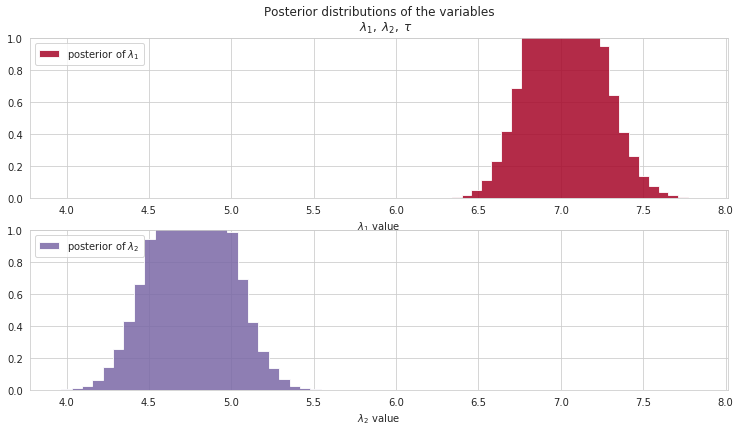

In [35]:
figsize(12.5, 10)
#histogram of the samples:
xlim = [min(lambda_1_samples.min(), lambda_2_samples.min()), max(lambda_1_samples.max(), lambda_2_samples.max())]
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim(xlim)
# plt.ylim([0, .75])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim(xlim)
# plt.ylim([0, .5])
plt.xlabel("$\lambda_2$ value")

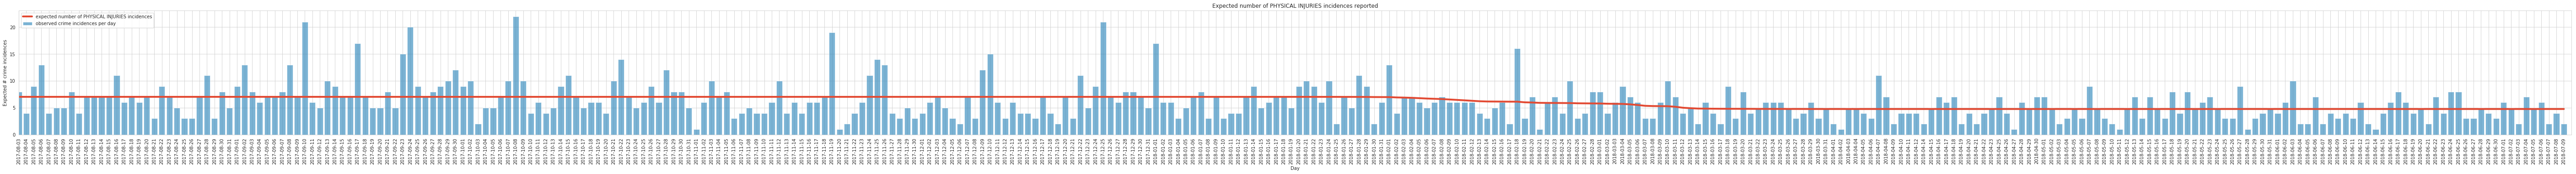

In [36]:
figsize(100, 5)
n_count_data = len(count_data)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_crime_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "crime incidence count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "crime incidence count".
    expected_crime_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_crime_per_day, lw=4, color="#E24A33",
         label="expected number of PHYSICAL INJURIES incidences")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # crime incidences")
plt.title("Expected number of PHYSICAL INJURIES incidences reported")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed crime incidences per day")
plt.xticks(np.arange(len(count_data)), count_data.index, rotation='vertical')
plt.legend(loc="upper left");

## Insights

1. There is no change in the in overall crime incidence reports for NCR, contrary to what was reported on Aug. 20, 2018.

2. Murder: 45% sudden decrease in October 2017
3. Theft: 33% sudden decrease in October 2017
4. Robbery: 19% Natural decrease
5. Rape: 28% natural decrease, may be underreported due to slowing down of reports at the most recent date
6. Vehicular Traffic Accidents: 14% sudden decrease in December 2017
7. Physical Injuries: 32% natural decrease, may be underreported due to slowing down of reports at the most recent date

## Opinions and Next Steps
1. What can possibly explain the sudden drop in crime incidence reports for certain types of activities?
2. Conduct Spatiotemporal analysis to factor in spatial distributions.